# Import Package

In [1]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Timestep = 1

In [2]:
TIMESTEP = 1

In [3]:
prof_df = pd.read_excel('C:/Users/muham/Documents/SIDE/PUSKA API/datasets/dummy/prof_farm.xlsx')
prof_df.head()

,ds,y
0,2022-04-01,10.20
1,2022-04-02,10.35
2,2022-04-03,10.70
3,2022-04-04,11.90
4,2022-04-05,12.00


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
prof_df[['y']] = scaler.fit_transform(prof_df[['y']])

In [5]:
joblib.dump(scaler, f'result/scaler/SCALER_T{TIMESTEP}.joblib')

['result/scaler/SCALER_T1.joblib']

In [6]:
prof_df['y-1'] = prof_df['y'].shift(1)
prof_df = prof_df.iloc[TIMESTEP:, :].reset_index(drop=True)
prof_df.head()

,ds,y,y-1
0,2022-04-02,0.218291,0.210401
1,2022-04-03,0.236701,0.218291
2,2022-04-04,0.299821,0.236701
3,2022-04-05,0.305081,0.299821
4,2022-04-06,0.241961,0.305081


In [7]:
split_index = round(0.8 * len(prof_df))

train_df = prof_df.iloc[:split_index, :]
test_df = prof_df.iloc[split_index:, :]

In [8]:
x_columns = ['y-1']

In [9]:
x_train = train_df[x_columns].values
# x_train = x_train.reshape(-1, 1)

x_test = test_df[x_columns].values
# x_test = x_test.reshape(-1, 1)

y_train = train_df['y'].values
y_test = test_df['y'].values

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

## Model

In [11]:
tf.random.set_seed(10)

In [12]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, TIMESTEP)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
472/472 - 2s - loss: 0.1104 - 2s/epoch - 4ms/step
Epoch 2/100
472/472 - 0s - loss: 0.0334 - 466ms/epoch - 988us/step
Epoch 3/100
472/472 - 0s - loss: 0.0265 - 459ms/epoch - 972us/step
Epoch 4/100
472/472 - 0s - loss: 0.0194 - 450ms/epoch - 953us/step
Epoch 5/100
472/472 - 0s - loss: 0.0128 - 447ms/epoch - 947us/step
Epoch 6/100
472/472 - 0s - loss: 0.0078 - 496ms/epoch - 1ms/step
Epoch 7/100
472/472 - 0s - loss: 0.0050 - 435ms/epoch - 921us/step
Epoch 8/100
472/472 - 0s - loss: 0.0040 - 435ms/epoch - 921us/step
Epoch 9/100
472/472 - 0s - loss: 0.0037 - 448ms/epoch - 948us/step
Epoch 10/100
472/472 - 0s - loss: 0.0037 - 433ms/epoch - 918us/step
Epoch 11/100
472/472 - 0s - loss: 0.0037 - 445ms/epoch - 942us/step
Epoch 12/100
472/472 - 0s - loss: 0.0037 - 487ms/epoch - 1ms/step
Epoch 13/100
472/472 - 0s - loss: 0.0036 - 449ms/epoch - 951us/step
Epoch 14/100
472/472 - 0s - loss: 0.0036 - 444ms/epoch - 942us/step
Epoch 15/100
472/472 - 0s - loss: 0.0036 - 456ms/epoch - 966us/ste

In [13]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

4/4 [==============================] - 0s 1ms/step


In [14]:
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

In [15]:
y_act = list(y_train[0]) + list(y_test[0])
y_pred = list(train_pred[:, 0]) + list(test_pred[:, 0])
y_pred = [round(y, 2) for y in y_pred]

In [16]:
def custom_round(x, decimal_places=2):
    factor = 10 ** decimal_places
    return round(x * factor) / factor

In [17]:
evaluation_df = pd.DataFrame(columns=['ds', 'y_act', 'y_pred'])
evaluation_df['ds'] = prof_df['ds']
evaluation_df['y_act'] = y_act
evaluation_df['y_pred'] = y_pred
evaluation_df['y_pred'] = evaluation_df['y_pred'].apply(custom_round)

evaluation_df.head(5)

,ds,y_act,y_pred
0,2022-04-02,10.35,10.40
1,2022-04-03,10.70,10.52
2,2022-04-04,11.90,10.81
3,2022-04-05,12.00,11.86
4,2022-04-06,10.80,11.96


In [18]:
train_pred = evaluation_df.iloc[:split_index, :]
test_pred = evaluation_df.iloc[split_index:, :]

In [19]:
mse = mean_squared_error(train_pred['y_act'], train_pred['y_pred'])
rmse = sqrt(mse)

rsquare = r2_score(train_pred['y_act'], train_pred['y_pred'])
mape = mean_absolute_percentage_error(train_pred['y_act'], train_pred['y_pred'])

print('--------------------')
print('Evaluation Train Data')
print('--------------------')

print(f'RMSE: {round(rmse, 4)}')
print(f'MAPE: {round(mape, 4)}')
print(f'RSquare: {round(rsquare, 4)}')

--------------------
Evaluation Train Data
--------------------
RMSE: 1.1227
MAPE: 0.0514
RSquare: 0.9097


In [20]:
mse = mean_squared_error(test_pred['y_act'], test_pred['y_pred'])
rmse = sqrt(mse)

rsquare = r2_score(test_pred['y_act'], test_pred['y_pred'])
mape = mean_absolute_percentage_error(test_pred['y_act'], test_pred['y_pred'])

print('--------------------')
print('Evaluation Test Data')
print('--------------------')

print(f'RMSE: {round(rmse, 4)}')
print(f'MAPE: {round(mape, 4)}')
print(f'RSquare: {round(rsquare, 4)}')

--------------------
Evaluation Test Data
--------------------
RMSE: 1.49
MAPE: 0.0601
RSquare: 0.5595


In [21]:
evaluation_df.set_index('ds', inplace=True)

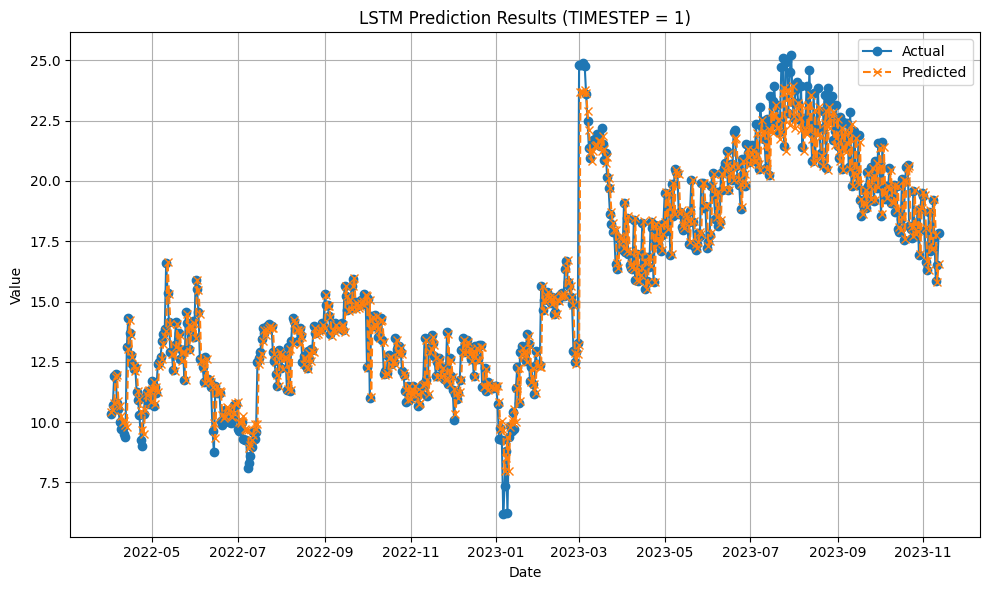

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(evaluation_df.index, evaluation_df['y_act'], label='Actual', linestyle='-', marker='o')
plt.plot(evaluation_df.index, evaluation_df['y_pred'], label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'LSTM Prediction Results (TIMESTEP = {TIMESTEP})')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'C:/Users/muham/Documents/SIDE/PUSKA API/plots/modelling/daily/jawa timur/probolinggo/nyx farm/plots/LSTM-T{TIMESTEP}.jpg')
plt.show()

In [23]:
model.save(f'result/model/LSTM_T{TIMESTEP}.h5')

c:\Users\muham\Documents\SIDE\PUSKA API\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Timestep = 2

In [24]:
TIMESTEP = 2

In [25]:
prof_df = pd.read_excel('C:/Users/muham/Documents/SIDE/PUSKA API/datasets/dummy/prof_farm.xlsx')
prof_df.head()

,ds,y
0,2022-04-01,10.20
1,2022-04-02,10.35
2,2022-04-03,10.70
3,2022-04-04,11.90
4,2022-04-05,12.00


In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
prof_df[['y']] = scaler.fit_transform(prof_df[['y']])

In [27]:
joblib.dump(scaler, f'result/scaler/SCALER_T{TIMESTEP}.joblib')

['result/scaler/SCALER_T2.joblib']

In [28]:
prof_df['y-1'] = prof_df['y'].shift(1)
prof_df['y-2'] = prof_df['y'].shift(2)
prof_df = prof_df.iloc[TIMESTEP:, :].reset_index(drop=True)
prof_df.head()

,ds,y,y-1,y-2
0,2022-04-03,0.236701,0.218291,0.210401
1,2022-04-04,0.299821,0.236701,0.218291
2,2022-04-05,0.305081,0.299821,0.236701
3,2022-04-06,0.241961,0.305081,0.299821
4,2022-04-07,0.228811,0.241961,0.305081


In [29]:
split_index = round(0.8 * len(prof_df))

train_df = prof_df.iloc[:split_index, :]
test_df = prof_df.iloc[split_index:, :]

In [30]:
x_columns = ['y-1', 'y-2']

In [31]:
x_train = train_df[x_columns].values
# x_train = x_train.reshape(-1, 1)

x_test = test_df[x_columns].values
# x_test = x_test.reshape(-1, 1)

y_train = train_df['y'].values
y_test = test_df['y'].values

In [32]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

## Model

In [33]:
tf.random.set_seed(10)

In [34]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, TIMESTEP)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
471/471 - 2s - loss: 0.0716 - 2s/epoch - 3ms/step
Epoch 2/100
471/471 - 0s - loss: 0.0152 - 433ms/epoch - 920us/step
Epoch 3/100
471/471 - 0s - loss: 0.0088 - 428ms/epoch - 910us/step
Epoch 4/100
471/471 - 0s - loss: 0.0051 - 428ms/epoch - 908us/step
Epoch 5/100
471/471 - 0s - loss: 0.0039 - 448ms/epoch - 951us/step
Epoch 6/100
471/471 - 0s - loss: 0.0036 - 425ms/epoch - 902us/step
Epoch 7/100
471/471 - 0s - loss: 0.0036 - 448ms/epoch - 951us/step
Epoch 8/100
471/471 - 0s - loss: 0.0036 - 429ms/epoch - 911us/step
Epoch 9/100
471/471 - 0s - loss: 0.0035 - 430ms/epoch - 913us/step
Epoch 10/100
471/471 - 0s - loss: 0.0035 - 440ms/epoch - 935us/step
Epoch 11/100
471/471 - 0s - loss: 0.0036 - 433ms/epoch - 918us/step
Epoch 12/100
471/471 - 0s - loss: 0.0036 - 431ms/epoch - 914us/step
Epoch 13/100
471/471 - 0s - loss: 0.0035 - 431ms/epoch - 915us/step
Epoch 14/100
471/471 - 0s - loss: 0.0035 - 446ms/epoch - 947us/step
Epoch 15/100
471/471 - 0s - loss: 0.0036 - 433ms/epoch - 920us

In [35]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

4/4 [==============================] - 0s 1ms/step


In [36]:
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

In [37]:
y_act = list(y_train[0]) + list(y_test[0])
y_pred = list(train_pred[:, 0]) + list(test_pred[:, 0])
y_pred = [round(y, 2) for y in y_pred]

In [38]:
def custom_round(x, decimal_places=2):
    factor = 10 ** decimal_places
    return round(x * factor) / factor

In [39]:
evaluation_df = pd.DataFrame(columns=['ds', 'y_act', 'y_pred'])
evaluation_df['ds'] = prof_df['ds']
evaluation_df['y_act'] = y_act
evaluation_df['y_pred'] = y_pred
evaluation_df['y_pred'] = evaluation_df['y_pred'].apply(custom_round)

evaluation_df.head(5)

,ds,y_act,y_pred
0,2022-04-03,10.70,10.86
1,2022-04-04,11.90,11.14
2,2022-04-05,12.00,12.07
3,2022-04-06,10.80,12.44
4,2022-04-07,10.55,11.60


In [40]:
train_pred = evaluation_df.iloc[:split_index, :]
test_pred = evaluation_df.iloc[split_index:, :]

In [41]:
mse = mean_squared_error(train_pred['y_act'], train_pred['y_pred'])
rmse = sqrt(mse)

rsquare = r2_score(train_pred['y_act'], train_pred['y_pred'])
mape = mean_absolute_percentage_error(train_pred['y_act'], train_pred['y_pred'])

print('--------------------')
print('Evaluation Train Data')
print('--------------------')

print(f'RMSE: {round(rmse, 4)}')
print(f'MAPE: {round(mape, 4)}')
print(f'RSquare: {round(rsquare, 4)}')

--------------------
Evaluation Train Data
--------------------
RMSE: 1.1887
MAPE: 0.0633
RSquare: 0.8987


In [42]:
mse = mean_squared_error(test_pred['y_act'], test_pred['y_pred'])
rmse = sqrt(mse)

rsquare = r2_score(test_pred['y_act'], test_pred['y_pred'])
mape = mean_absolute_percentage_error(test_pred['y_act'], test_pred['y_pred'])

print('--------------------')
print('Evaluation Test Data')
print('--------------------')

print(f'RMSE: {round(rmse, 4)}')
print(f'MAPE: {round(mape, 4)}')
print(f'RSquare: {round(rsquare, 4)}')

--------------------
Evaluation Test Data
--------------------
RMSE: 1.4802
MAPE: 0.0621
RSquare: 0.5653


In [43]:
evaluation_df.set_index('ds', inplace=True)

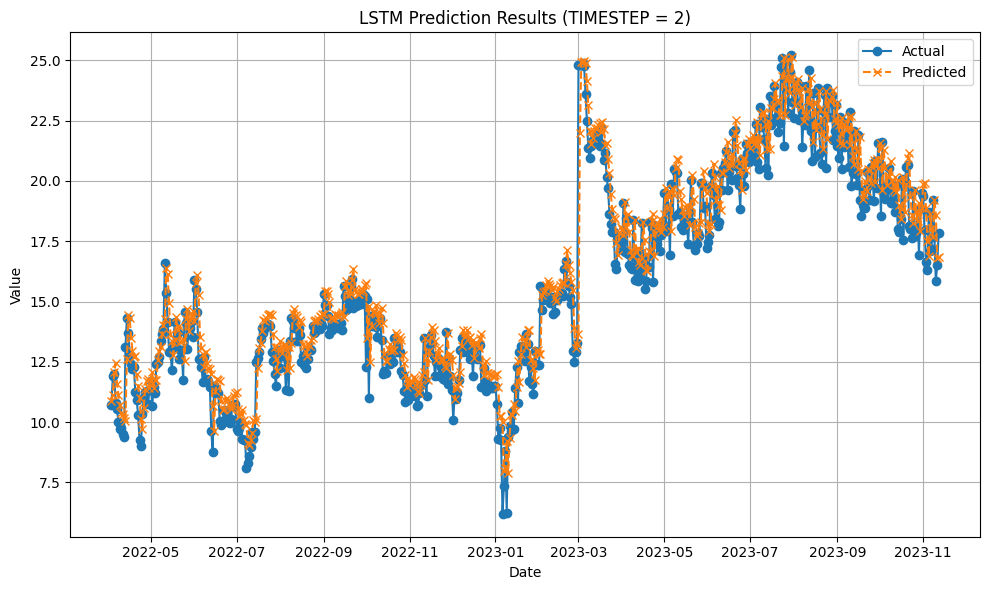

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(evaluation_df.index, evaluation_df['y_act'], label='Actual', linestyle='-', marker='o')
plt.plot(evaluation_df.index, evaluation_df['y_pred'], label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LSTM Prediction Results (TIMESTEP = 2)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'C:/Users/muham/Documents/SIDE/PUSKA API/plots/modelling/daily/jawa timur/probolinggo/nyx farm/plots/LSTM-T{TIMESTEP}.jpg')
plt.show()

In [45]:
model.save(f'result/model/LSTM_T{TIMESTEP}.h5')

c:\Users\muham\Documents\SIDE\PUSKA API\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
